#Dependências

In [6]:
from load_mnist import load_data
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

from objectivefunc import model_function, other_params_model
import optuna

2024-05-21 21:47:00.942153: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 21:47:00.988947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 21:47:00.989353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 21:47:01.808473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Modelo Inicial

In [10]:
learning_rate = 0.001
epochs = 5
num_classes = 10

In [8]:
training_data, validation_data, test_data = load_data()
training_data = list(training_data)
test_data = list(test_data)

In [9]:
X_train, X_test, y_train, y_test = training_data[0], test_data[0], training_data[1], test_data[1]

X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),  # Flatten the data for dense layers
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=num_classes, activation='softmax')  # Output layer with softmax for probabilities
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy'])


/home/caio-barreto/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.fit(X_train, y_train, epochs=epochs)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8970 - loss: 0.3262
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9853 - loss: 0.0472
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9907 - loss: 0.0288
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9930 - loss: 0.0204
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9948 - loss: 0.0162


In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9869 - loss: 0.0413
Test Accuracy: 0.9900000095367432


In [16]:
predictions = model.predict(X_test)

predicted_labels = predictions.argmax(axis=1)

cm = confusion_matrix(y_test, predicted_labels)

for i in range(num_classes):
  accuracy = cm[i, i] / cm[i, :].sum()
  print(f"Accuracy for class {i}: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for digit 0: 0.9929
Accuracy for digit 1: 0.9956
Accuracy for digit 2: 0.9913
Accuracy for digit 3: 0.9970
Accuracy for digit 4: 0.9919
Accuracy for digit 5: 0.9753
Accuracy for digit 6: 0.9927
Accuracy for digit 7: 0.9805
Accuracy for digit 8: 0.9877
Accuracy for digit 9: 0.9931


In [17]:
predicted_labels = predictions.argmax(axis=1)

report = classification_report(y_test, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



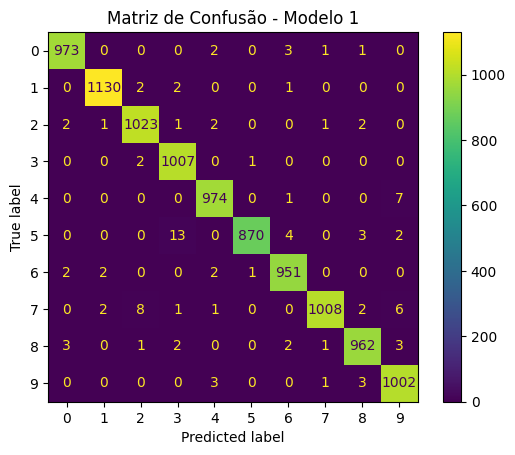

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão - Modelo 1')
plt.show()


# Otimização de parâmetros com Optuna

#### Estudo 1: Learning Rate, Epochs, Batch Size, No. of filters, Dense Units

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(other_params_model, n_trials=10)

[I 2024-05-20 23:14:39,412] A new study created in memory with name: no-name-68045c57-fcb9-45a7-81b9-86ae609308b0
[I 2024-05-20 23:16:03,898] Trial 0 finished with value: 0.9851999878883362 and parameters: {'learning_rate': 0.007949254734482034, 'epochs': 8, 'batch_size': 106, 'num_filters': 32, 'dense_units': 196}. Best is trial 0 with value: 0.9851999878883362.
[I 2024-05-20 23:32:30,732] Trial 1 finished with value: 0.9907000064849854 and parameters: {'learning_rate': 0.0011090093878667155, 'epochs': 14, 'batch_size': 44, 'num_filters': 128, 'dense_units': 167}. Best is trial 1 with value: 0.9907000064849854.
[I 2024-05-20 23:42:06,683] Trial 2 finished with value: 0.9901999831199646 and parameters: {'learning_rate': 0.00034388105147047066, 'epochs': 9, 'batch_size': 57, 'num_filters': 128, 'dense_units': 73}. Best is trial 1 with value: 0.9907000064849854.
[I 2024-05-20 23:43:57,753] Trial 3 finished with value: 0.9793999791145325 and parameters: {'learning_rate': 9.426207367184762

In [ ]:
for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  - Parameters: {trial.params}")
    print(f"  - Metric value: {trial.value}\n")


Trial 0:
  - Parameters: {'learning_rate': 0.007949254734482034, 'epochs': 8, 'batch_size': 106, 'num_filters': 32, 'dense_units': 196}
  - Metric value: 0.9851999878883362

Trial 1:
  - Parameters: {'learning_rate': 0.0011090093878667155, 'epochs': 14, 'batch_size': 44, 'num_filters': 128, 'dense_units': 167}
  - Metric value: 0.9907000064849854

Trial 2:
  - Parameters: {'learning_rate': 0.00034388105147047066, 'epochs': 9, 'batch_size': 57, 'num_filters': 128, 'dense_units': 73}
  - Metric value: 0.9901999831199646

Trial 3:
  - Parameters: {'learning_rate': 9.426207367184762e-05, 'epochs': 5, 'batch_size': 88, 'num_filters': 64, 'dense_units': 118}
  - Metric value: 0.9793999791145325

Trial 4:
  - Parameters: {'learning_rate': 0.002818643058613451, 'epochs': 7, 'batch_size': 71, 'num_filters': 32, 'dense_units': 163}
  - Metric value: 0.9873999953269958

Trial 5:
  - Parameters: {'learning_rate': 1.9200968516406505e-05, 'epochs': 15, 'batch_size': 91, 'num_filters': 64, 'dense_uni

In [13]:
params = {
    'learning_rate': 0.0011090093878667155,
    'epochs': 14,
    'batch_size': 44,
    'num_filters': 128,
    'dense_units': 167
}

model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=params['num_filters'], kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=params['num_filters'] * 2, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=params['dense_units'], activation='relu'),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, verbose=1)

Epoch 1/14
910/910 [==============================] - 85s 92ms/step - loss: 0.1331 - accuracy: 0.9579 - val_loss: 0.1241 - val_accuracy: 0.9593
Epoch 2/14
910/910 [==============================] - 83s 91ms/step - loss: 0.0406 - accuracy: 0.9869 - val_loss: 0.0511 - val_accuracy: 0.9835
Epoch 3/14
910/910 [==============================] - 83s 91ms/step - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0537 - val_accuracy: 0.9842
Epoch 4/14
910/910 [==============================] - 81s 89ms/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 0.0433 - val_accuracy: 0.9873
Epoch 5/14
910/910 [==============================] - 78s 86ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0699 - val_accuracy: 0.9828
Epoch 6/14
910/910 [==============================] - 78s 86ms/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.0978 - val_accuracy: 0.9780
Epoch 7/14
910/910 [==============================] - 80s 88ms/step - loss: 0.0105 - accuracy: 0.9968 - val_loss: 0.0539 - val_accuracy:

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

313/313 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       1.00      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



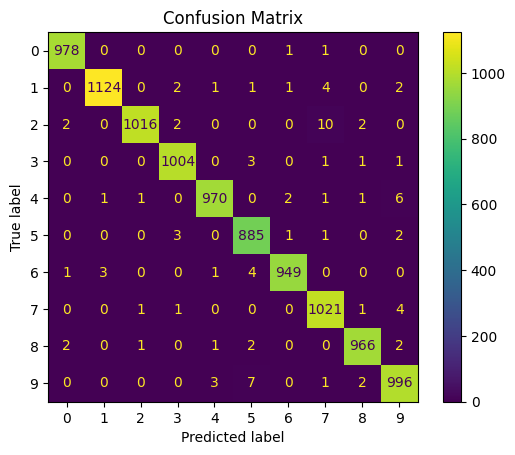

In [12]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprimir relatório de classificação
print(classification_report(y_test, y_pred_classes))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


#### Estudo 2: No. of filters, Filter size, Padding, Dropout Rate, Pool size

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(model_function, n_trials=10)

[I 2024-05-21 13:20:37,117] A new study created in memory with name: no-name-9fed91ce-0f71-4911-afe7-a33ab898e959
[I 2024-05-21 13:21:36,580] Trial 0 finished with value: 0.9804999828338623 and parameters: {'num_filters': 64, 'filter_size': 3, 'stride': 2, 'padding': 'valid', 'dropout_rate': 0.1, 'pool_size': 2}. Best is trial 0 with value: 0.9804999828338623.
[I 2024-05-21 13:28:05,435] Trial 1 finished with value: 0.9864000082015991 and parameters: {'num_filters': 128, 'filter_size': 5, 'stride': 2, 'padding': 'same', 'dropout_rate': 0.1, 'pool_size': 3}. Best is trial 1 with value: 0.9864000082015991.
[I 2024-05-21 13:29:37,513] Trial 2 finished with value: 0.9904000163078308 and parameters: {'num_filters': 32, 'filter_size': 5, 'stride': 1, 'padding': 'valid', 'dropout_rate': 0.1, 'pool_size': 3}. Best is trial 2 with value: 0.9904000163078308.
[I 2024-05-21 13:53:54,913] Trial 3 finished with value: 0.9925000071525574 and parameters: {'num_filters': 128, 'filter_size': 5, 'stride'

In [ ]:
for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  - Parameters: {trial.params}")
    print(f"  - Metric value: {trial.value}\n")


Trial 0:
  - Parameters: {'num_filters': 64, 'filter_size': 3, 'stride': 2, 'padding': 'valid', 'dropout_rate': 0.1, 'pool_size': 2}
  - Metric value: 0.9804999828338623

Trial 1:
  - Parameters: {'num_filters': 128, 'filter_size': 5, 'stride': 2, 'padding': 'same', 'dropout_rate': 0.1, 'pool_size': 3}
  - Metric value: 0.9864000082015991

Trial 2:
  - Parameters: {'num_filters': 32, 'filter_size': 5, 'stride': 1, 'padding': 'valid', 'dropout_rate': 0.1, 'pool_size': 3}
  - Metric value: 0.9904000163078308

Trial 3:
  - Parameters: {'num_filters': 128, 'filter_size': 5, 'stride': 1, 'padding': 'same', 'dropout_rate': 0.30000000000000004, 'pool_size': 3}
  - Metric value: 0.9925000071525574

Trial 4:
  - Parameters: {'num_filters': 32, 'filter_size': 3, 'stride': 2, 'padding': 'same', 'dropout_rate': 0.4, 'pool_size': 3}
  - Metric value: 0.9843999743461609

Trial 5:
  - Parameters: {'num_filters': 32, 'filter_size': 3, 'stride': 1, 'padding': 'valid', 'dropout_rate': 0.4, 'pool_size': 